# Advanced Lane Finding Project

The goals / steps of this project are the following:

- [x] Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- [x] Apply a distortion correction to raw images.
- [x] Use color transforms, gradients, etc., to create a thresholded binary image.
- [x] Apply a perspective transform to rectify binary image ("birds-eye view").
- [x] Detect lane pixels and fit to find the lane boundary.
- [x] Determine the curvature of the lane and vehicle position with respect to center.
- [x] Warp the detected lane boundaries back onto the original image.
- [x] Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Imports

In [1]:
# builtins
from glob import glob
import functools
import os

# third-party
import cv2
import numpy as np
import matplotlib.pyplot as plt

# project-specific
from src.calibrate import calibrate
from src.thresholding import region_of_interest, thresh, and_binary, or_binary, not_binary
from src.image_mappings import direction, magnitude, abs_sobel
from src.perspective import get_transformers

# display-related
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Calibration

Finding all calibration images...
calibration1.jpg (720w, 1280h)
calibration2.jpg (720w, 1280h)
calibration3.jpg (720w, 1280h)
calibration4.jpg (720w, 1280h)
calibration5.jpg (720w, 1280h)
calibration6.jpg (720w, 1280h)
calibration7.jpg (721w, 1281h)
calibration8.jpg (720w, 1280h)
calibration9.jpg (720w, 1280h)
calibration10.jpg (720w, 1280h)
calibration11.jpg (720w, 1280h)
calibration12.jpg (720w, 1280h)
calibration13.jpg (720w, 1280h)
calibration14.jpg (720w, 1280h)
calibration15.jpg (721w, 1281h)
calibration16.jpg (720w, 1280h)
calibration17.jpg (720w, 1280h)
calibration18.jpg (720w, 1280h)
calibration19.jpg (720w, 1280h)
calibration20.jpg (720w, 1280h)
Found 20 images.
Calibrating...
Calibrated using 17 chessboard images (was unable to use 3 images).
Writing to output_images/chessboards...
Written. Sample output with corners drawn:


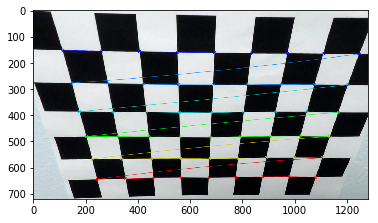

In [2]:
print("Finding all calibration images...")
calibration_image_paths = sorted(glob('./camera_cal/calibration*.jpg'), key=lambda p: (len(p), p))
calibration_images = list(map(cv2.imread, calibration_image_paths))
for path, image in zip(calibration_image_paths, calibration_images):
    print("{0} ({1[0]}w, {1[1]}h)".format(
        os.path.basename(path),
        image.shape
    ))
print("Found {} images.".format(len(calibration_images)))

print("Calibrating...")
used_calibration_images, object_points, all_corners, undistort, mtx, dist = calibrate(
    calibration_images, 
    chessboard_dimensions=(9, 6), 
    to_grayscale_flag=cv2.COLOR_BGR2GRAY
)
print("Calibrated using {} chessboard images (was unable to use {} images).".format(
    len(used_calibration_images), len(calibration_images) - len(used_calibration_images)
))

print("Writing to output_images/chessboards...")
directory = "output_images/chessboards"
try:
    os.mkdir(directory)
except:
    pass

for image, corners, i in zip(used_calibration_images, all_corners, range(len(used_calibration_images))):
    img = cv2.drawChessboardCorners(image, (9, 6), corners, True)
    cv2.imwrite(directory + "/{}.before.jpg".format(i), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    out = undistort(img)
    cv2.imwrite(directory + "/{}.after.jpg".format(i), cv2.cvtColor(out, cv2.COLOR_RGB2BGR))
    if i == 0:
        plt.imshow(out)

print("Written. Sample output with corners drawn:")

## Perspective Transform

Defining perspective transformers...
Done. Showing sample image, birds_eye, then conversion back:


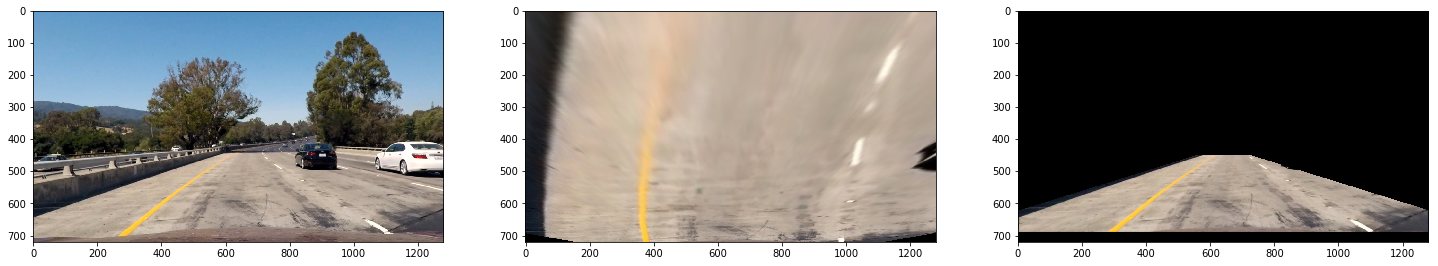

In [3]:
print("Defining perspective transformers...")
to_birds_eye, to_car_perspective = get_transformers(np.float32([
    [600, 450],
    [683, 450],
    [1060, 690],
    [253, 690],
]), np.float32([
    [350, 0],
    [950, 0],
    [950, 720],
    [350, 720],
]))

img = undistort(cv2.cvtColor(cv2.imread("test_images/test1.jpg"), cv2.COLOR_BGR2RGB))

f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(25, 9))
ax1.imshow(img)
ax2.imshow(to_birds_eye(img))
ax3.imshow(to_car_perspective(to_birds_eye(img)))
print("Done. Showing sample image, birds_eye, then conversion back:")

## Thresholding and Selector Composition

In [4]:
print("Defining image selectors...")

# The number fiddling below was gleaned from courses.
# I tried fiddling with numbers on my own. It brought endless frustration. I almost gave up on the entire program.
# The only way I could get passed this emotional roadblock was to go on to the next project and see what I would miss if I quit.
# Glad I didn't quit here.
# -James Fulford

def mag_thresh(gray):
    """Assumes grayscale image"""
    return thresh(magnitude(
        gray,
        sobel_kernel=9
    ), (30, 100))

def dir_thresh(gray):
    """Assumes grayscale image"""
    return thresh(direction(
        gray,
        sobel_kernel=15
    ), (0.7, 1.3))

def gray_thresh(gray):
    """Assumes grayscale image"""
    return thresh(direction(
        gray,
    ), (180, 256))

def r_thresh(img):
    """Assumes RGB"""
    return thresh(
        img[:,:,0],
        (200, 255)
    )

def s_thresh(hls):
    """Assumes HLS"""
    return thresh(
        hls[:,:,2],
        (170, 255)  # (90, 255)
    )

def sobelx_thresh(gray):
    """Assumes Grayscale"""
    return thresh(abs_sobel(
        gray,
        orient="x",
        sobel_kernel=3,
    ), (20, 100))

def h_thresh(hls):
    """Assumes HLS"""
    return thresh(
        hls[:,:,0],
        (15, 100)
    )


# Final selectors
def comp1(img, gray, hls):
    """
    First composition. Resembles composition given in course. Takes out too much data.
    """
    return or_binary(sobelx_thresh(gray), s_thresh(hls))

def comp2(img, gray, hls):
    """
    Second composition. Can sometimes be noisy. Captures color well (right saturation or redness).
    """
    return or_binary(r_thresh(img), s_thresh(hls))

def comp3(img, gray, hls):
    return and_binary(not_binary(h_thresh(hls)), dir_thresh(gray))

def lane_selector(img):
    """
    Keeps pixels which appear in at least 2 of my composed images.
    Assumes RGB
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    c1 = comp1(img, gray, hls)
    c2 = comp2(img, gray, hls)
    c3 = comp3(img, gray, hls)
    return and_binary(or_binary(c1, c3), c2)

print("Defined.")

Defining image selectors...
Defined.


Showing samples using the selectors...
Done.


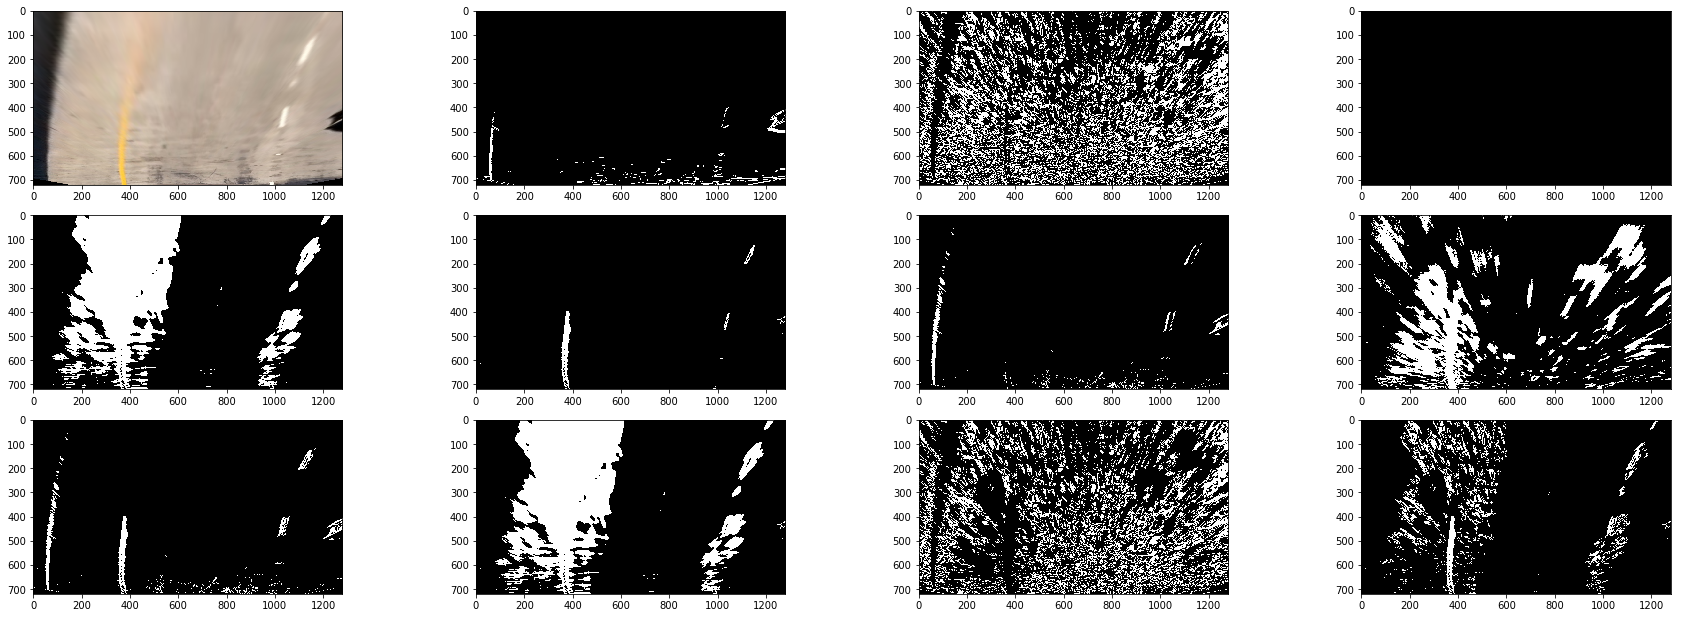

In [5]:
print("Showing samples using the selectors...")

img = to_birds_eye(undistort(cv2.cvtColor(cv2.imread("test_images/test1.jpg"), cv2.COLOR_BGR2RGB)))
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

f, (
    (ax11, ax12, ax13, ax14),
    (ax21, ax22, ax23, ax24),
    (ax31, ax32, ax33, ax34),
) = plt.subplots(nrows=3, ncols=4, figsize=(24, 9))
f.tight_layout()

# Original image
ax11.imshow(img)

# Building blocks
ax12.imshow(mag_thresh(gray), cmap="gray")
ax13.imshow(dir_thresh(gray), cmap="gray")
ax14.imshow(gray_thresh(gray), cmap="gray")

ax21.imshow(r_thresh(img), cmap="gray")
ax22.imshow(s_thresh(hls), cmap="gray")
ax23.imshow(sobelx_thresh(gray), cmap="gray")
ax24.imshow(h_thresh(hls), cmap="gray")

# Useful-looking compositions
ax31.imshow(comp1(img, gray, hls), cmap="gray")  # comp1
ax32.imshow(comp2(img, gray, hls), cmap="gray")  # comp2
ax33.imshow(comp3(img, gray, hls), cmap="gray")  # comp3

# Pixels which show up in at least 2 of the above compositions (inefficient calculation)
ax34.imshow(lane_selector(img), cmap="gray")

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
print("Done.")

## Detect Lane Pixels and Fit Quadratics

Defining lane pixel detectors...
Curvatures (m):  [1181.1511414978686, 569.9758868401867]
Offset from lane center (m):  -0.09192348635144472
Done. Showing fit on sample image:


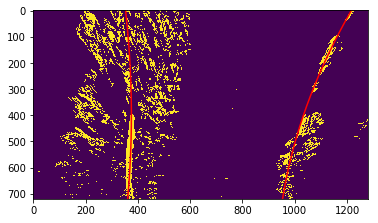

In [6]:
print("Defining lane pixel detectors...")

ym_per_pix = 30 / 720  # meters per pixel in y dimension
xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

def get_lane_start(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return (leftx_base, rightx_base)

def get_lane_pixels(img, nwindows=12, margin=50, minpix=30):
    window_height = np.int(img.shape[0] // nwindows)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # to debug:
    # out_img = np.dstack((img, img, img))

    lane_inds = [
        [],  # left lane
        [],  # right lane
    ]
    current = list(get_lane_start(img))  # leftx_current, rightx_current

    for window in range(nwindows):
        window_boundaries = list(
            map(lambda b: (b - margin, b + margin), current)
        )
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = img.shape[0] - window * window_height
        
        for i, bound in enumerate(window_boundaries):
            leftx, rightx = bound
            
            # to debug:
            # cv2.rectangle(out_img, (leftx, win_y_low), (rightx, win_y_high), (0, 255, 0), 2) 

            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= leftx) &  (nonzerox < rightx)).nonzero()[0]
            
            lane_inds[i].append(good_inds)
            
            if len(good_inds) > minpix:
                current[i] = np.int(np.mean(nonzerox[good_inds]))

    # to debug:
    # plt.imshow(out_img)
    lane_inds = list(map(np.concatenate, lane_inds))
    return [(nonzerox[inds], nonzeroy[inds]) for inds in lane_inds ]


def fit_polynomials(img, ym_per_pix=ym_per_pix, xm_per_pix=xm_per_pix):
    """
    Returns tuple of lists, equal in length:
    - First is coefficients of each quadratic polynomial
    - Second is a series of x values to graph for each polynomial
    """
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])    
    lane_pixels = get_lane_pixels(img)
    quads = list(map(
        lambda vp: np.polyfit(vp[1] * ym_per_pix, vp[0] * xm_per_pix, 2),
        lane_pixels,
    ))
    return quads, list(map(
        lambda fit: fit[0] * (ploty ** 2)
            + fit[1] * (ploty ** 1)
            + fit[2], 
        quads,
    ))

def curvature(y_eval, quad, ym_per_pix=ym_per_pix):
    (a, b, c) = quad
    return ((1 + (2 * a * (y_eval * ym_per_pix) + b) ** 2) ** 1.5) / np.absolute(2 * a)

def get_lane_offset_from_center(image, left_fit, right_fit, xm_per_pix=xm_per_pix):
    # Find lane offsets in pixel space, convert to real
    lane_bottom_px_xvalues = list(map(lambda f: f[-1], [left_fit, right_fit]))
    lane_center_px_x = sum(lane_bottom_px_xvalues) / len(lane_bottom_px_xvalues)
    camera_location_px_x = image.shape[1] / 2
    return (camera_location_px_x - lane_center_px_x) * xm_per_pix

img = lane_selector(to_birds_eye(undistort(cv2.cvtColor(cv2.imread("test_images/test1.jpg"), cv2.COLOR_BGR2RGB))))
# Make quadratics in pixel space
quads, [ left_fit, right_fit ] = fit_polynomials(img, ym_per_pix=1, xm_per_pix=1)
# Make quadratics in real space
real_quads, [ real_left_fit, real_right_fit ] = fit_polynomials(img)

# Find curvatures in real space
ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
y_eval = np.max(ploty)
print("Curvatures (m): ", list(map(
    lambda q: curvature(y_eval, q),
    real_quads,
)))

print("Offset from lane center (m): ", get_lane_offset_from_center(image, left_fit, right_fit ))

plt.plot(left_fit, ploty, color='red')
plt.plot(right_fit, ploty, color='red')
plt.imshow(img)

print("Done. Showing fit on sample image:")

## Full Pipeline

Defining full pipeline...
Drawing zone on sample road...
Done.


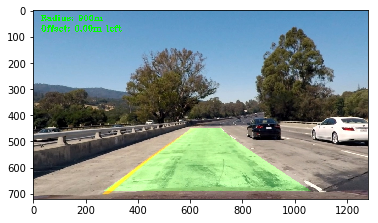

In [7]:
print("Defining full pipeline...")


def get_zone(binary_warped, left_fit, right_fit, undist):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Drawing a polygon for the zone
    pts_left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))  # draw zone as green
    
    # Warping zone image to car's perspective
    newwarp = to_car_perspective(color_warp)
    return newwarp

class State:
    initialized = False
    warp = None
    offset = 0
    lcurve = None
    rcurve = None
    lfit = 0
    rfit = 0

def full_pipeline(img, state=False):
    """
    Given distorted camera image in RGB,
    returns undistorted camera image (based on calibration) with lane zone and annotations added.
    Holds no state between successive calls.
    """
    undist = undistort(img)
    warped = to_birds_eye(undist)
    binary_warped = lane_selector(warped)
    [ lquad, rquad ], [ left_fit, right_fit ] = fit_polynomials(binary_warped, ym_per_pix=1, xm_per_pix=1)
    real_quads, [ real_left_fit, real_right_fit ] = fit_polynomials(binary_warped)  # real space
    
    # Calculations
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    [ lcurve, rcurve ] = list(map(
        lambda q: curvature(y_eval, q),
        real_quads,
    ))
    curve = (lcurve + rcurve) / 2
    offset = get_lane_offset_from_center(binary_warped, left_fit, right_fit)
    
    # Prepare annotations
    
    newwarp = None  # all cases will overwrite
    if state:
        # Check for bad situation
        if (
            (left_fit > right_fit - 120).any()  # lines get too close to intersecting
            or abs(offset - State.offset) > 0.25  # car jumped too far
            or abs(offset) > (3.7 / 2)  # car is outside of lane
            or lquad[0] * rquad[0] < 0  # concavity of quadratics have different signs (they curve different ways)
        ):
            if State.initialized:
                newwarp = State.warp  # use last zone drawing
            else:
                newwarp = get_zone(binary_warped, left_fit, right_fit, undist)
                # not initializing with bad values!
        else:
            # Use weighted average with previous state to build new lines
            # (old measurements will exponentially become less relevant over iterations)
            l = left_fit * 0.6 + State.lfit * 0.4
            r = right_fit * 0.6 + State.rfit * 0.4
            newwarp = get_zone(binary_warped, l, r, undist)
            # Set good values in state
            State.initialized = True
            State.warp = newwarp
            State.offset = offset
            State.lcurve = l
            State.rcurve = r
            
            State.lfit = left_fit
            State.rfit = right_fit
    else:
        newwarp = get_zone(binary_warped, left_fit, right_fit, undist)
        
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    result = cv2.putText(
        result, 
        'Radius: {}m'.format(int(round(curve ** 0.5) ** 2)),  # Trickery to have this jump more meaningfully
        # This rounds to the square number whose root is closest to this number's root.
        # (I used squares because curvature calculations are roughly quadratic in nature.)
        (30, 40),
        cv2.FONT_HERSHEY_TRIPLEX,
        1,
        (0, 255, 0),
        2
    )
    result = cv2.putText(
        result, 
        'Offset: {}m {}'.format(round(abs(offset), 2), "left" if offset < 0 else "right"),
        (30, 80),
        cv2.FONT_HERSHEY_TRIPLEX,
        1,
        (0, 255, 0),
        2
    )
    
    return result

print("Drawing zone on sample road...")
img = cv2.cvtColor(cv2.imread("test_images/test1.jpg"), cv2.COLOR_BGR2RGB)
result = full_pipeline(img)
plt.imshow(result)
print("Done.")

# Processing for Display

## Process Images

In [8]:
print("Producing pipeline middle step sample images...")

images = sorted(glob("test_images/*.jpg"), key=lambda p: (len(p), p))

for image_name in images:
    img = cv2.imread(image_name)
    directory = "output_images/" + os.path.basename(image_name)
    try:
        os.mkdir(directory)
    except:
        pass
    print(directory)

    cv2.imwrite(directory + "/00_original.jpg", img)
    
    # Undistort image (virtue of camera lens)
    undis = undistort(img)
    cv2.imwrite(directory + "/01_undistorted.jpg", undis)
    
    # Perspective transform
    birds_eye = to_birds_eye(undis)
    cv2.imwrite(directory + "/02_perspective_transform.jpg", birds_eye)

    # Lanes
    lanes = lane_selector(birds_eye)
    plt.imsave(directory + "/03_lane_selector.jpg", lanes, cmap='gray')
    
    # Fitting polynomials
    ploty = np.linspace(0, lanes.shape[0] - 1, lanes.shape[0])
    quads, [ left_fit, right_fit ] = fit_polynomials(lanes, ym_per_pix=1, xm_per_pix=1)
    
    plt.imshow(lanes)
    plt.plot(left_fit, ploty, color='red')
    plt.plot(right_fit, ploty, color='red')
    plt.savefig(directory + "/04_plotted_lines.jpg")
    plt.clf()
plt.close()
print("Done.")

Producing pipeline middle step sample images...
output_images/test1.jpg
output_images/test2.jpg
output_images/test3.jpg
output_images/test4.jpg
output_images/test5.jpg
output_images/test6.jpg
output_images/straight_lines1.jpg
output_images/straight_lines2.jpg
Done.


In [9]:
for image_name in images:
    img = cv2.imread(image_name)
    directory = "output_images/" + os.path.basename(image_name)
    try:
        os.mkdir(directory)
    except:
        pass
    print(directory)
    
    plt.imsave(directory + "/05_pipeline_result.jpg", full_pipeline(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), state=False))

output_images/test1.jpg
output_images/test2.jpg
output_images/test3.jpg
output_images/test4.jpg
output_images/test5.jpg
output_images/test6.jpg
output_images/straight_lines1.jpg
output_images/straight_lines2.jpg


## Processing Video

In [10]:
output_path = "output_videos/project_video.mp4"
clip = VideoFileClip("project_video.mp4")
output_video = clip.fl_image(lambda i: full_pipeline(i, state=True))
%time output_video.write_videofile(output_path, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [04:24<00:00,  4.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 4min 17s, sys: 27.6 s, total: 4min 44s
Wall time: 4min 25s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path))